导入必要的库

In [1]:
import cv2
import numpy as np
np.random.seed(42)
import json
import matplotlib.pyplot as plt

import bpu_infer_lib

定义必要的函数

In [2]:
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    label = "{0} ({1:.2f})".format(classes[class_id], confidence)
    color = colors[class_id]
    cv2.rectangle(img, (x, y), (x_plus_w, y_plus_h), color, 2)
    cv2.putText(img, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 3)

In [3]:
def nms(boxes, scores, iou_threshold):
    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes

In [4]:
def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou

In [5]:
with open('offline_vocabulary_embeddings.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
    json_keys = data.keys()
    json_keys_list = list(json_keys)
    classes = json_keys_list
    input_voc = ["dog"]
    key_indexs = []
    text_embeddings = []
    for voc in input_voc:
        if voc in json_keys_list:
            key_index = json_keys_list.index(voc)
            key_indexs.append(key_index)
            text_embedding = np.array(data[voc], dtype=np.float32)
            text_embeddings.append(text_embedding)
key_indexs += [key_indexs[-1]] * (32 - len(key_indexs)) # padding
key_indexs = np.array(key_indexs) # shape (32,)
text_embeddings += [text_embeddings[-1]] * (32 - len(text_embeddings))
text_embeddings = np.array(text_embeddings).reshape(1, 32, -1) # shape (1,32,512), float32

In [6]:
image = cv2.imread('dog.jpeg', cv2.IMREAD_COLOR)
resize_scale = 640. / max(image.shape[:2])
scale = max((image.shape[0], image.shape[1])) / 640
image_resized = cv2.resize(image, (0, 0), fy=resize_scale, fx=resize_scale)
input_image = np.zeros((640, 640, 3), dtype=np.float32)
input_image[:image_resized.shape[0], :image_resized.shape[1], :] = image_resized
input_image = input_image[:, :, [2, 1, 0]]  # bgr->rgb
input_image = input_image[None].transpose(0, 3, 1, 2) # shape - (1,3,640,640), float32

inf = bpu_infer_lib.Infer(False)
inf.load_model("yolo_world.bin")
print("Number of model's inputs:", len(inf.inputs))
print("Input[0]'s tensor layout:", inf.inputs[0].properties.tensorLayout)
print("Input[0]'s tensor type:", inf.inputs[0].properties.tensorType)
print("Input[1]'s tensor layout:", inf.inputs[1].properties.tensorLayout)
print("Input[1]'s tensor type:", inf.inputs[1].properties.tensorType)
print("Number of model's outputs:", len(inf.outputs))
print("Output[0]'s tensor layout:", inf.outputs[0].properties.tensorLayout)
print("Output[0]'s tensor type:", inf.outputs[0].properties.tensorType)
print("Output[1]'s tensor layout:", inf.outputs[1].properties.tensorLayout)
print("Output[1]'s tensor type:", inf.outputs[1].properties.tensorType)
inf.read_input(input_image, 0)
inf.read_input(text_embeddings, 1)
inf.forward()
inf.get_output()

classes_scores = inf.outputs[0].data.squeeze(-1)
print("classes_scores has shape:", classes_scores.shape)
bboxes = inf.outputs[1].data.squeeze(-1)
print("bboxes has shape:", bboxes.shape)

The model path is valid and points to a regular file.
Number of model's inputs: 2
Input[0]'s tensor layout: HB_DNN_LAYOUT_NCHW
Input[0]'s tensor type: HB_DNN_TENSOR_TYPE_F32
Input[1]'s tensor layout: HB_DNN_LAYOUT_NCHW
Input[1]'s tensor type: HB_DNN_TENSOR_TYPE_F32
Number of model's outputs: 2
Output[0]'s tensor layout: HB_DNN_LAYOUT_NCHW
Output[0]'s tensor type: HB_DNN_TENSOR_TYPE_F32
Output[1]'s tensor layout: HB_DNN_LAYOUT_NCHW
Output[1]'s tensor type: HB_DNN_TENSOR_TYPE_F32
[BPU_PLAT]BPU Platform Version(1.3.6)!
[HBRT] set log level as 0. version = 3.15.49.0
[DNN] Runtime version = 1.23.8_(3.15.49 HBRT)
[A][DNN][packed_model.cpp:247][Model](2000-01-01,13:04:32.237.313) [HorizonRT] The model builder version = 1.23.6
input size checked!!
input dtype checked pass!!
input size checked!!
input dtype checked pass!!
classes_scores has shape: (1, 8400, 32)
bboxes has shape: (1, 8400, 4)


boxes:  [[0.7842265, 125.76516, 321.65668, 640.83685], [1.2382523, 125.971535, 314.76373, 642.05444], [1.4859028, 126.03345, 315.5273, 641.00195], [3.7766695, 125.558784, 314.45416, 635.2441], [0.7635889, 123.742676, 322.39963, 640.1352], [0.7635889, 125.60006, 315.17648, 639.7224], [0.61912614, 125.53815, 315.83688, 639.41284], [0.47466338, 124.6301, 314.76373, 639.41284], [0.7429514, 115.19874, 315.32095, 639.9907], [0.3302006, 115.15746, 315.63052, 639.8669]]
scores:  [0.311924546957016, 0.2925295829772949, 0.3158869445323944, 0.2873888909816742, 0.21687769889831543, 0.3405075669288635, 0.4214758574962616, 0.4153997004032135, 0.2291724979877472, 0.3035261034965515]


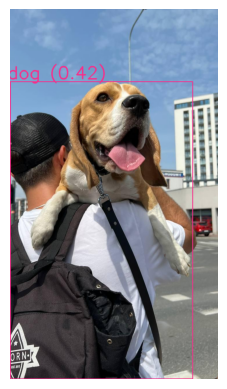

In [7]:
rows = classes_scores.shape[1]

boxes = []
scores = []
class_ids = []

for i in range(rows):
    classes_score = classes_scores[0][i]
    (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_score)
    if maxScore >= 0.05:
        box = [
            bboxes[0][i][0],
            bboxes[0][i][1],
            bboxes[0][i][2],
            bboxes[0][i][3]
        ]
        boxes.append(box)
        scores.append(maxScore)
        class_ids.append(maxClassIndex)

print("boxes: ", boxes)
print("scores: ", scores)
result_boxes = nms(np.array(boxes), np.array(scores), 0.45)

detections = []
for i in range(len(result_boxes)):
    index = result_boxes[i]
    box = boxes[index]
    detection = {
        'class_id': key_indexs[class_ids[index]],
        'class_name': classes[key_indexs[class_ids[index]]],
        'confidence': scores[index],
        'box': box,
        'scale': scale
    }
    detections.append(detection)
    draw_bounding_box(
        image, key_indexs[class_ids[index]], scores[index],
        round(box[0] * scale), round(box[1] * scale),
        round((box[2]) * scale), round((box[3]) * scale)
    )

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Display the image using Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.show()